# Carregar dados em um data warehouse relacional

## Como usar o comando COPY

Use a instrução COPY para carregar dados do data lake, conforme mostrado no seguinte exemplo:

In [ ]:
COPY INTO dbo.StageProduct
    (ProductID, ProductName, ...)
FROM 'https://mydatalake.../data/products*.parquet'
WITH
(
    FILE_TYPE = 'PARQUET',
    MAXERRORS = 0,
    IDENTITY_INSERT = 'OFF'
);

## Usando tabelas externas

Em alguns casos, se os dados a serem carregados estiverem armazenados em arquivos com uma estrutura apropriada, poderá ser mais eficaz criar tabelas externas que referenciem o local do arquivo. Dessa forma, os dados podem ser lidos diretamente dos arquivos de origem em vez de serem carregados no repositório relacional. O seguinte exemplo mostra como criar uma tabela externa que referencia arquivos no data lake associado ao workspace do Azure Synapse Analytics:

In [ ]:
CREATE EXTERNAL TABLE dbo.ExternalStageProduct
 (
     ProductID NVARCHAR(10) NOT NULL,
     ProductName NVARCHAR(10) NOT NULL,
 ...
 )
WITH
 (
    DATE_SOURCE = StagedFiles,
    LOCATION = 'folder_name/*.parquet',
    FILE_FORMAT = ParquetFormat
 );
GO

## Carregar tabelas de dimensões temporais

As tabelas de dimensão de tempo armazenam um registro para cada intervalo de tempo com base no grão pelo qual você deseja agregar dados ao longo do tempo. Por exemplo, uma tabela de dimensões temporais com a granularidade data contém um registro para cada data entre as datas mais antiga e mais recente referenciadas pelos dados nas tabelas de fatos relacionadas.

O exemplo de código a seguir mostra como você pode gerar uma sequência de valores de dimensão de tempo com base em um grão de data.

In [ ]:
-- Create a temporary table for the dates we need
CREATE TABLE #TmpStageDate (DateVal DATE NOT NULL)

-- Populate the temp table with a range of dates
DECLARE @StartDate DATE
DECLARE @EndDate DATE
SET @StartDate = '2019-01-01'
SET @EndDate = '2023-12-31'
DECLARE @LoopDate = @StartDate
WHILE @LoopDate <= @EndDate
BEGIN
    INSERT INTO #TmpStageDate VALUES
    (
        @LoopDate
    )
    SET @LoopDate = DATEADD(dd, 1, @LoopDate)
END

-- Insert the dates and calculated attributes into the dimension table
INSERT INTO dbo.DimDate
SELECT CAST(CONVERT(VARCHAR(8), DateVal, 112) as INT), -- date key
    DateVal, --date alt key
    Day(DateVal) -- day number of month
    --,  other derived temporal fields as required
FROM #TmpStageDate
GO

--Drop temporary table
DROP TABLE #TmpStageDate

## Executar a otimização pós-carregamento

Depois de carregar novos dados no data warehouse, é uma boa ideia recompilar os índices de tabela e atualizar estatísticas em colunas comumente consultadas.

Recompilar índices

O exemplo a seguir recria todos os índices na tabela DimProduct:

In [ ]:
ALTER INDEX ALL ON dbo.DimProduct REBUILD

Atualizar estatísticas

O exemplo a seguir cria estatísticas na coluna ProductCategory da tabela DimProduct :

In [ ]:
CREATE STATISTICS productcategory_stats
ON dbo.DimProduct(ProductCategory);

# (Lab Pratico)Carregar dados em um data warehouse relacional

In [ ]:
 rm -r dp-203 -f
 git clone https://github.com/MicrosoftLearning/dp-203-azure-data-engineer dp-203

In [ ]:
 cd dp-203/Allfiles/labs/09
 ./setup.ps1

Na página Visão geral do seu Synapse Workspace, no cartão Abrir Synapse Studio, selecione Abrir para abrir o Synapse Studio em uma nova guia do navegador

Na página Gerenciar, na guia Pools de SQL, selecione a linha para o pool de SQL dedicado sqlxxxxxxx, que hospeda o data warehouse para este exercício, e use o ícone ▷ para iniciá-lo;

## Carregar dados de um data lake usando a instrução COPY

In [ ]:
 SELECT COUNT(1)
 FROM dbo.StageProduct

Na barra de ferramentas, use o botão ▷ Executar para executar o código SQL e confirmar se há 0 linhas atualmente na tabela StageProduct.

Execute o script e revise os resultados. 11 linhas devem ter sido carregadas na tabela StageProduct:

In [ ]:
 COPY INTO dbo.StageProduct
     (ProductID, ProductName, ProductCategory, Color, Size, ListPrice, Discontinued)
 FROM 'https://datalakexxxxxx.blob.core.windows.net/files/data/Product.csv'
 WITH
 (
     FILE_TYPE = 'CSV',
     MAXERRORS = 0,
     IDENTITY_INSERT = 'OFF',
     FIRSTROW = 2 --Skip header row
 );


 SELECT COUNT(1)
 FROM dbo.StageProduct

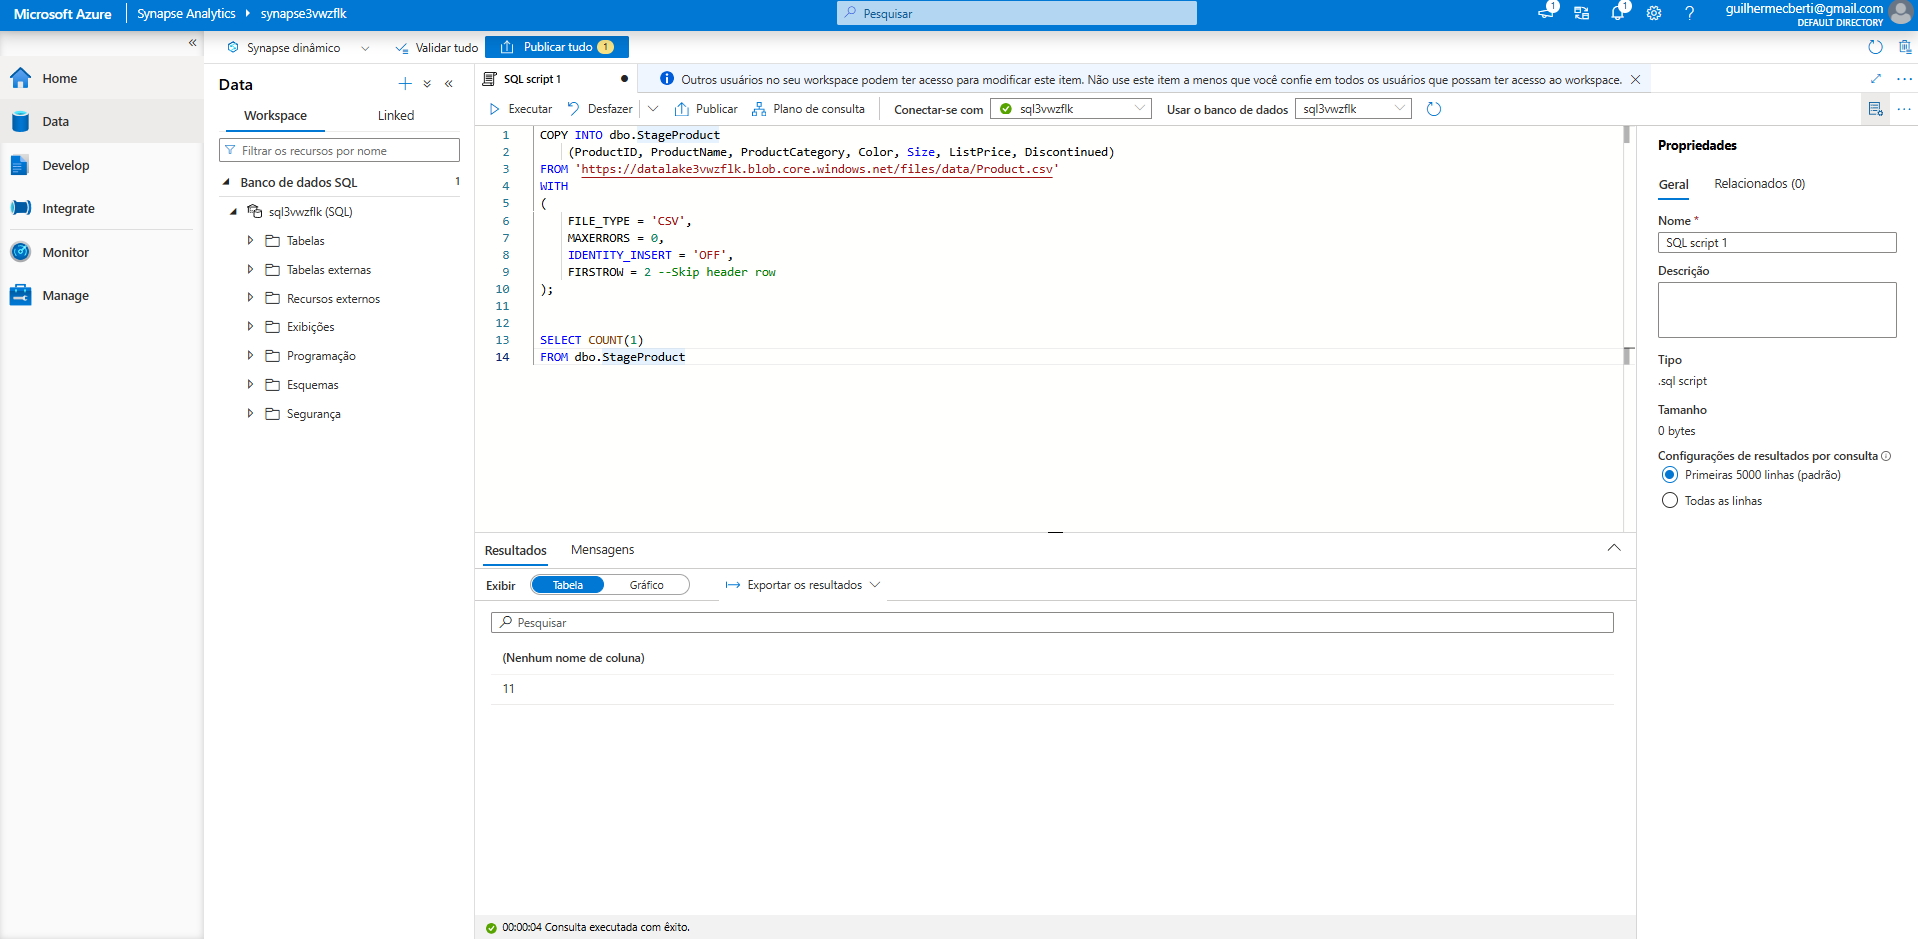

Execute o script e revise a mensagem resultante. O arquivo de origem contém uma linha com dados inválidos, portanto, uma linha é rejeitada.

In [ ]:
 COPY INTO dbo.StageCustomer
 (GeographyKey, CustomerAlternateKey, Title, FirstName, MiddleName, LastName, NameStyle, BirthDate,
 MaritalStatus, Suffix, Gender, EmailAddress, YearlyIncome, TotalChildren, NumberChildrenAtHome, EnglishEducation,
 SpanishEducation, FrenchEducation, EnglishOccupation, SpanishOccupation, FrenchOccupation, HouseOwnerFlag,
 NumberCarsOwned, AddressLine1, AddressLine2, Phone, DateFirstPurchase, CommuteDistance)
 FROM 'https://datalakexxxxxx.dfs.core.windows.net/files/data/Customer.csv'
 WITH
 (
 FILE_TYPE = 'CSV'
 ,MAXERRORS = 5
 ,FIRSTROW = 2 -- skip header row
 ,ERRORFILE = 'https://datalakexxxxxx.dfs.core.windows.net/files/'
 );

O código acima especifica um máximo de 5 erros, portanto, um único erro não deveria ter impedido o carregamento das linhas válidas. Você pode visualizar as linhas que foram carregadas executando a seguinte consulta.

In [ ]:
 SELECT *
 FROM dbo.StageCustomer

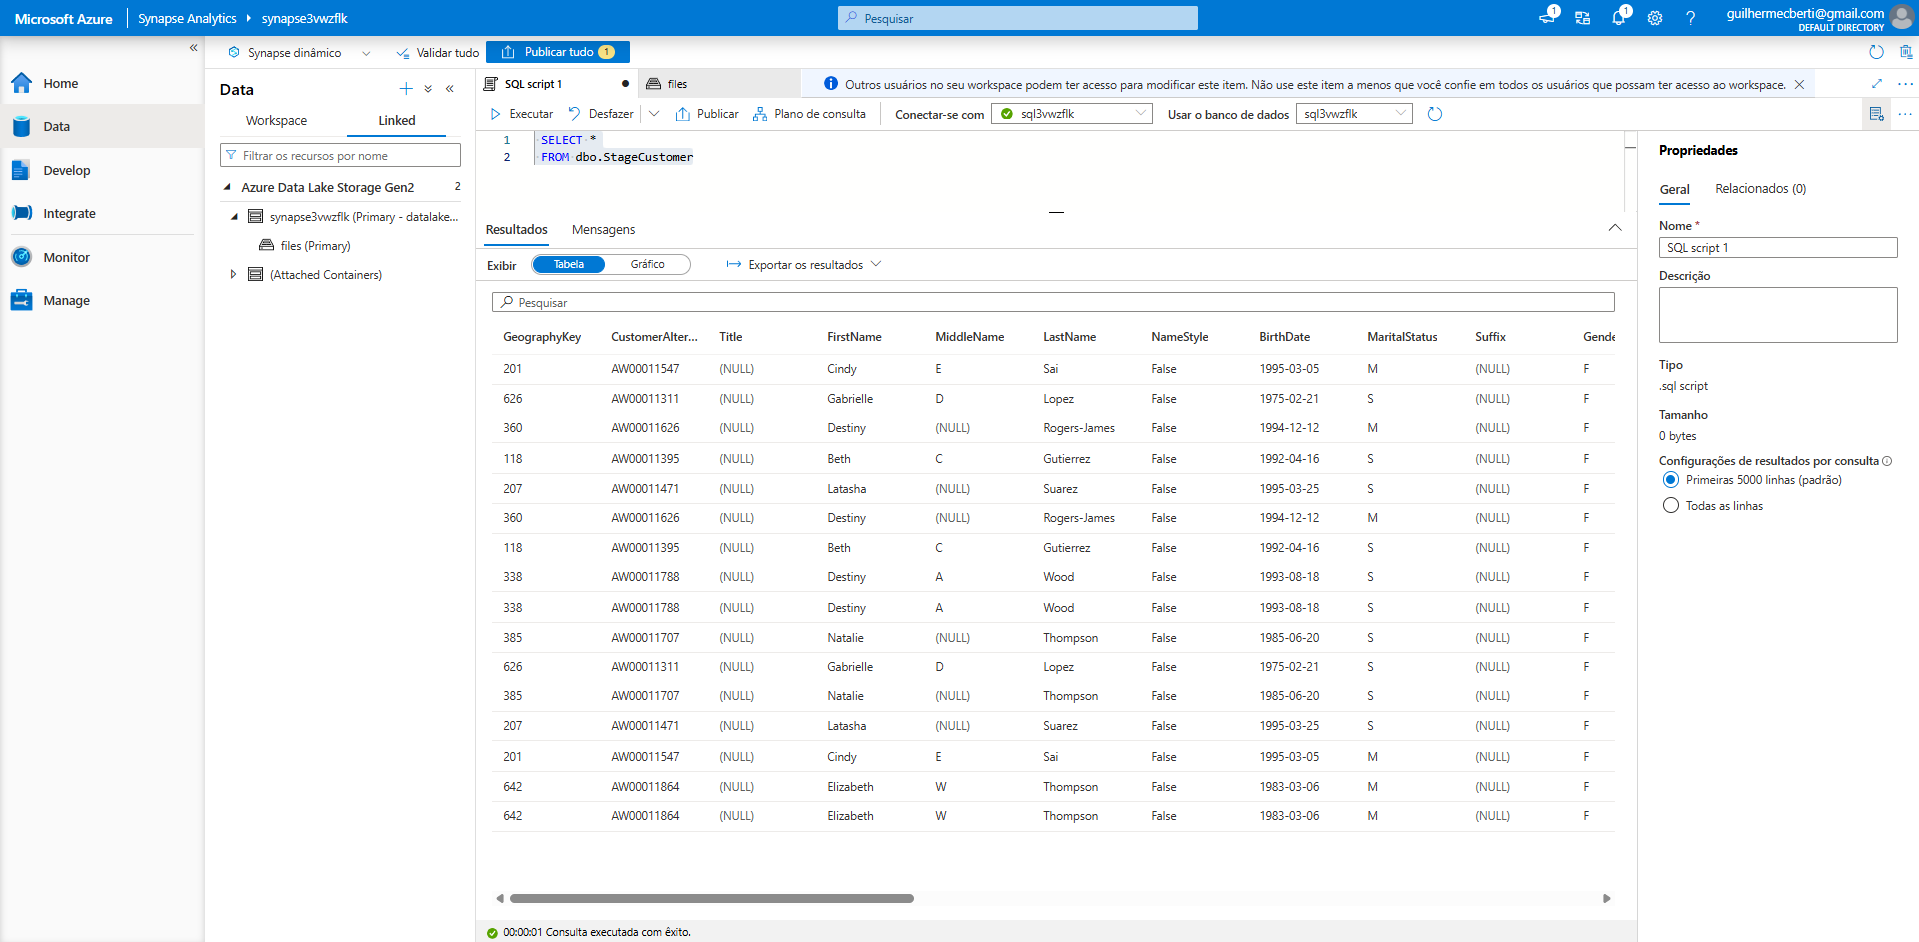

Abra a pasta _rejectedrows e a subpasta específica de data e hora que ela contém e observe que arquivos com nomes semelhantes a QID123_1_2.Error.Txt e QID123_1_2.Row.Txt foram criados.

Você pode clicar com o botão direito do mouse em cada um desses arquivos e selecionar Visualizar para ver detalhes do erro e da linha que foi rejeitada.

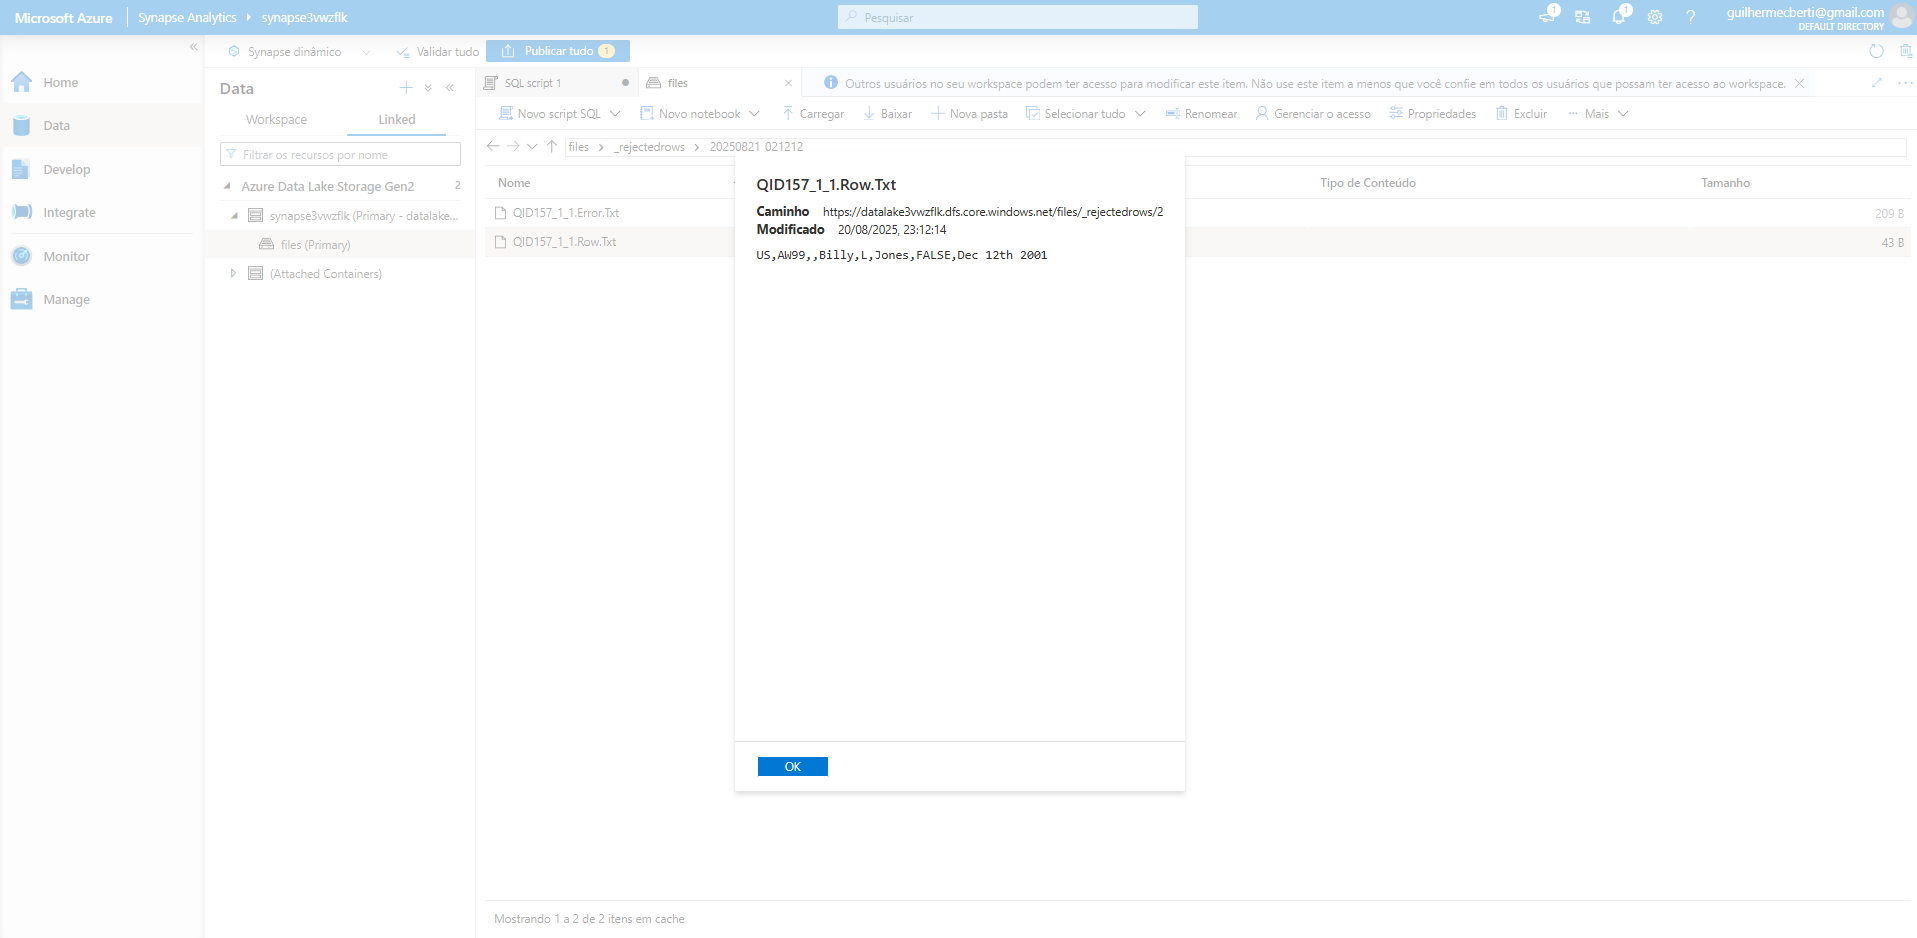

## Use uma instrução CREATE TABLE AS (CTAS)

Execute o script, que cria uma nova tabela chamada DimProduct a partir dos dados do produto preparado que usa ProductAltKey como sua chave de distribuição de hash e tem um índice columnstore agrupado.

In [ ]:
 CREATE TABLE dbo.DimProduct
 WITH
 (
     DISTRIBUTION = HASH(ProductAltKey),
     CLUSTERED COLUMNSTORE INDEX
 )
 AS
 SELECT ROW_NUMBER() OVER(ORDER BY ProductID) AS ProductKey,
     ProductID AS ProductAltKey,
     ProductName,
     ProductCategory,
     Color,
     Size,
     ListPrice,
     Discontinued
 FROM dbo.StageProduct;

Use a seguinte consulta para visualizar o conteúdo da nova tabela DimProduct:

In [ ]:
 SELECT ProductKey,
     ProductAltKey,
     ProductName,
     ProductCategory,
     Color,
     Size,
     ListPrice,
     Discontinued
 FROM dbo.DimProduct;

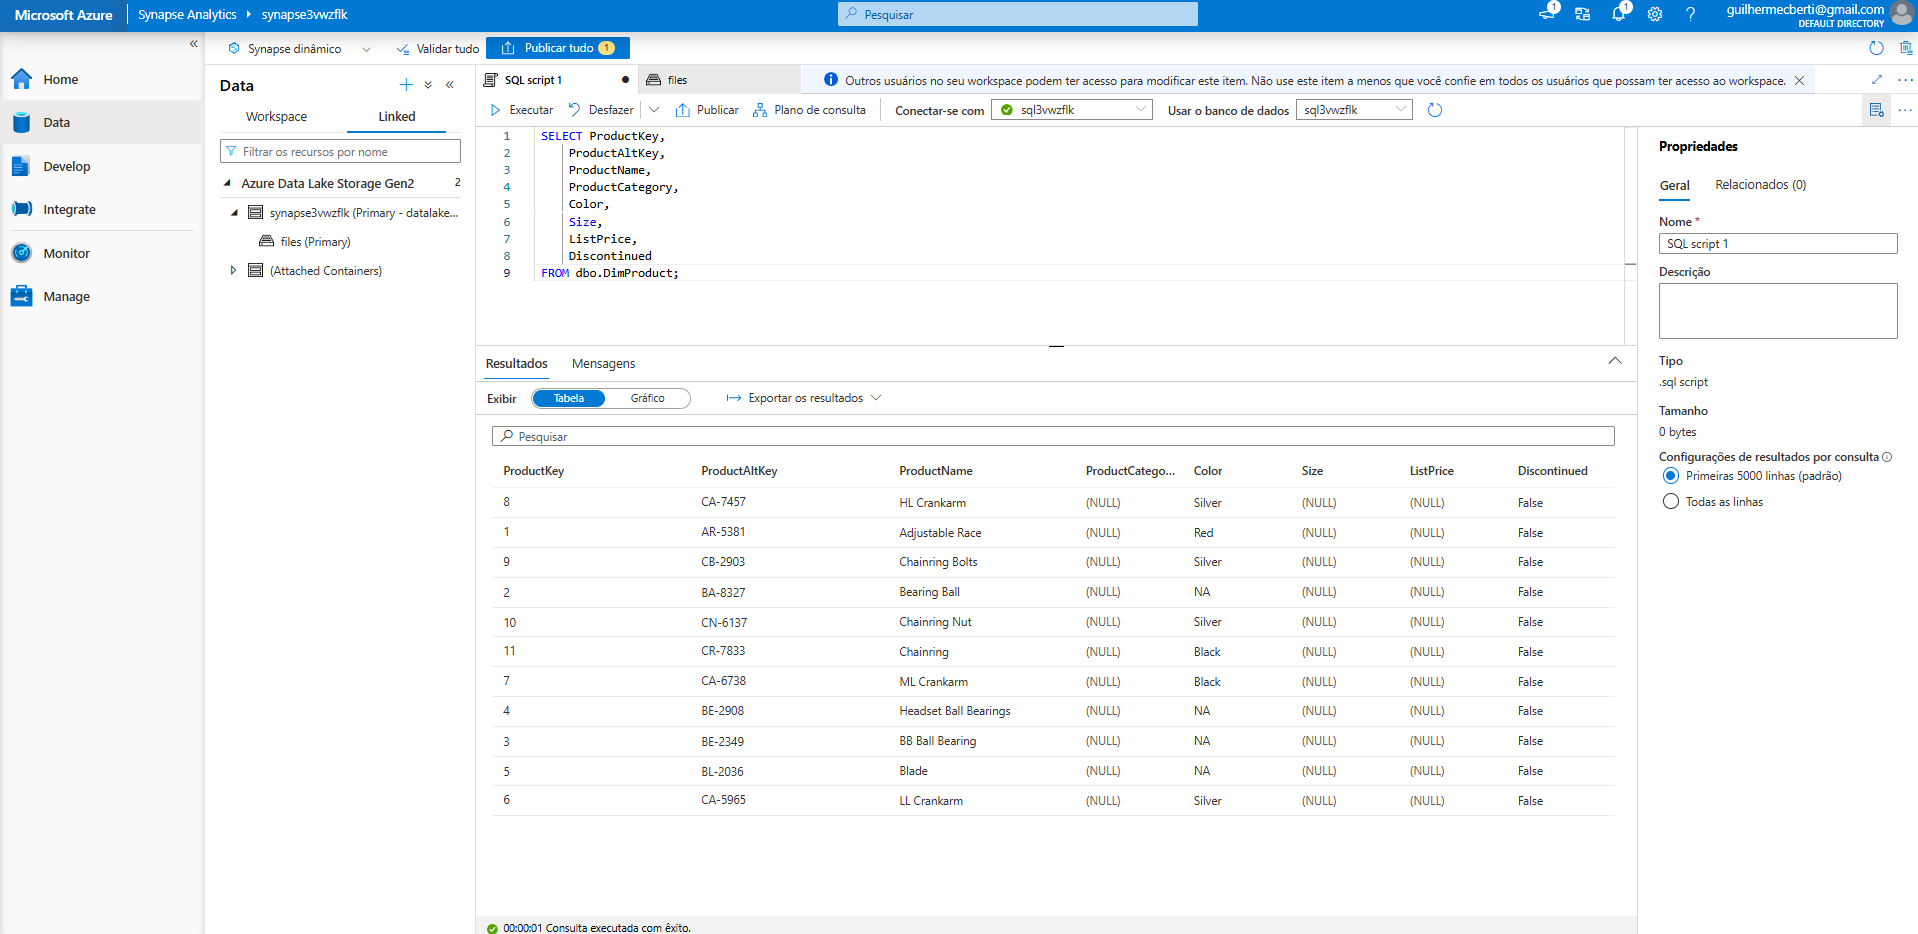

A expressão CREATE TABLE AS SELECT (CTAS) tem vários usos, incluindo:

Redistribuir a chave de hash de uma tabela para alinhamento com outras tabelas, melhorando o desempenho das consultas.

Atribuir uma chave substituta a uma tabela de preparação com base nos valores existentes após a execução de uma análise delta.

Criar tabelas agregadas rapidamente para fins de relatório.

## Combine as instruções INSERT e UPDATE para carregar uma tabela de dimensões que muda lentamente

A tabela DimCustomer oferece suporte a dimensões de alteração lenta (SCDs) do tipo 1 e do tipo 2, onde as alterações do tipo 1 resultam em uma atualização no local de uma linha existente, e as alterações do tipo 2 resultam em uma nova linha para indicar a versão mais recente de uma instância de entidade de dimensão específica.

Carregar esta tabela requer uma combinação de instruções INSERT (para carregar novos clientes) e instruções UPDATE (para aplicar alterações do tipo 1 ou tipo 2).

In [ ]:
 INSERT INTO dbo.DimCustomer ([GeographyKey],[CustomerAlternateKey],[Title],[FirstName],[MiddleName],[LastName],[NameStyle],[BirthDate],[MaritalStatus],
 [Suffix],[Gender],[EmailAddress],[YearlyIncome],[TotalChildren],[NumberChildrenAtHome],[EnglishEducation],[SpanishEducation],[FrenchEducation],
 [EnglishOccupation],[SpanishOccupation],[FrenchOccupation],[HouseOwnerFlag],[NumberCarsOwned],[AddressLine1],[AddressLine2],[Phone],
 [DateFirstPurchase],[CommuteDistance])
 SELECT *
 FROM dbo.StageCustomer AS stg
 WHERE NOT EXISTS
     (SELECT * FROM dbo.DimCustomer AS dim
     WHERE dim.CustomerAlternateKey = stg.CustomerAlternateKey);

 -- Type 1 updates (change name, email, or phone in place)
 UPDATE dbo.DimCustomer
 SET LastName = stg.LastName,
     EmailAddress = stg.EmailAddress,
     Phone = stg.Phone
 FROM DimCustomer dim inner join StageCustomer stg
 ON dim.CustomerAlternateKey = stg.CustomerAlternateKey
 WHERE dim.LastName <> stg.LastName OR dim.EmailAddress <> stg.EmailAddress OR dim.Phone <> stg.Phone

 -- Type 2 updates (address changes triggers new entry)
 INSERT INTO dbo.DimCustomer
 SELECT stg.GeographyKey,stg.CustomerAlternateKey,stg.Title,stg.FirstName,stg.MiddleName,stg.LastName,stg.NameStyle,stg.BirthDate,stg.MaritalStatus,
 stg.Suffix,stg.Gender,stg.EmailAddress,stg.YearlyIncome,stg.TotalChildren,stg.NumberChildrenAtHome,stg.EnglishEducation,stg.SpanishEducation,stg.FrenchEducation,
 stg.EnglishOccupation,stg.SpanishOccupation,stg.FrenchOccupation,stg.HouseOwnerFlag,stg.NumberCarsOwned,stg.AddressLine1,stg.AddressLine2,stg.Phone,
 stg.DateFirstPurchase,stg.CommuteDistance
 FROM dbo.StageCustomer AS stg
 JOIN dbo.DimCustomer AS dim
 ON stg.CustomerAlternateKey = dim.CustomerAlternateKey
 AND stg.AddressLine1 <> dim.AddressLine1;

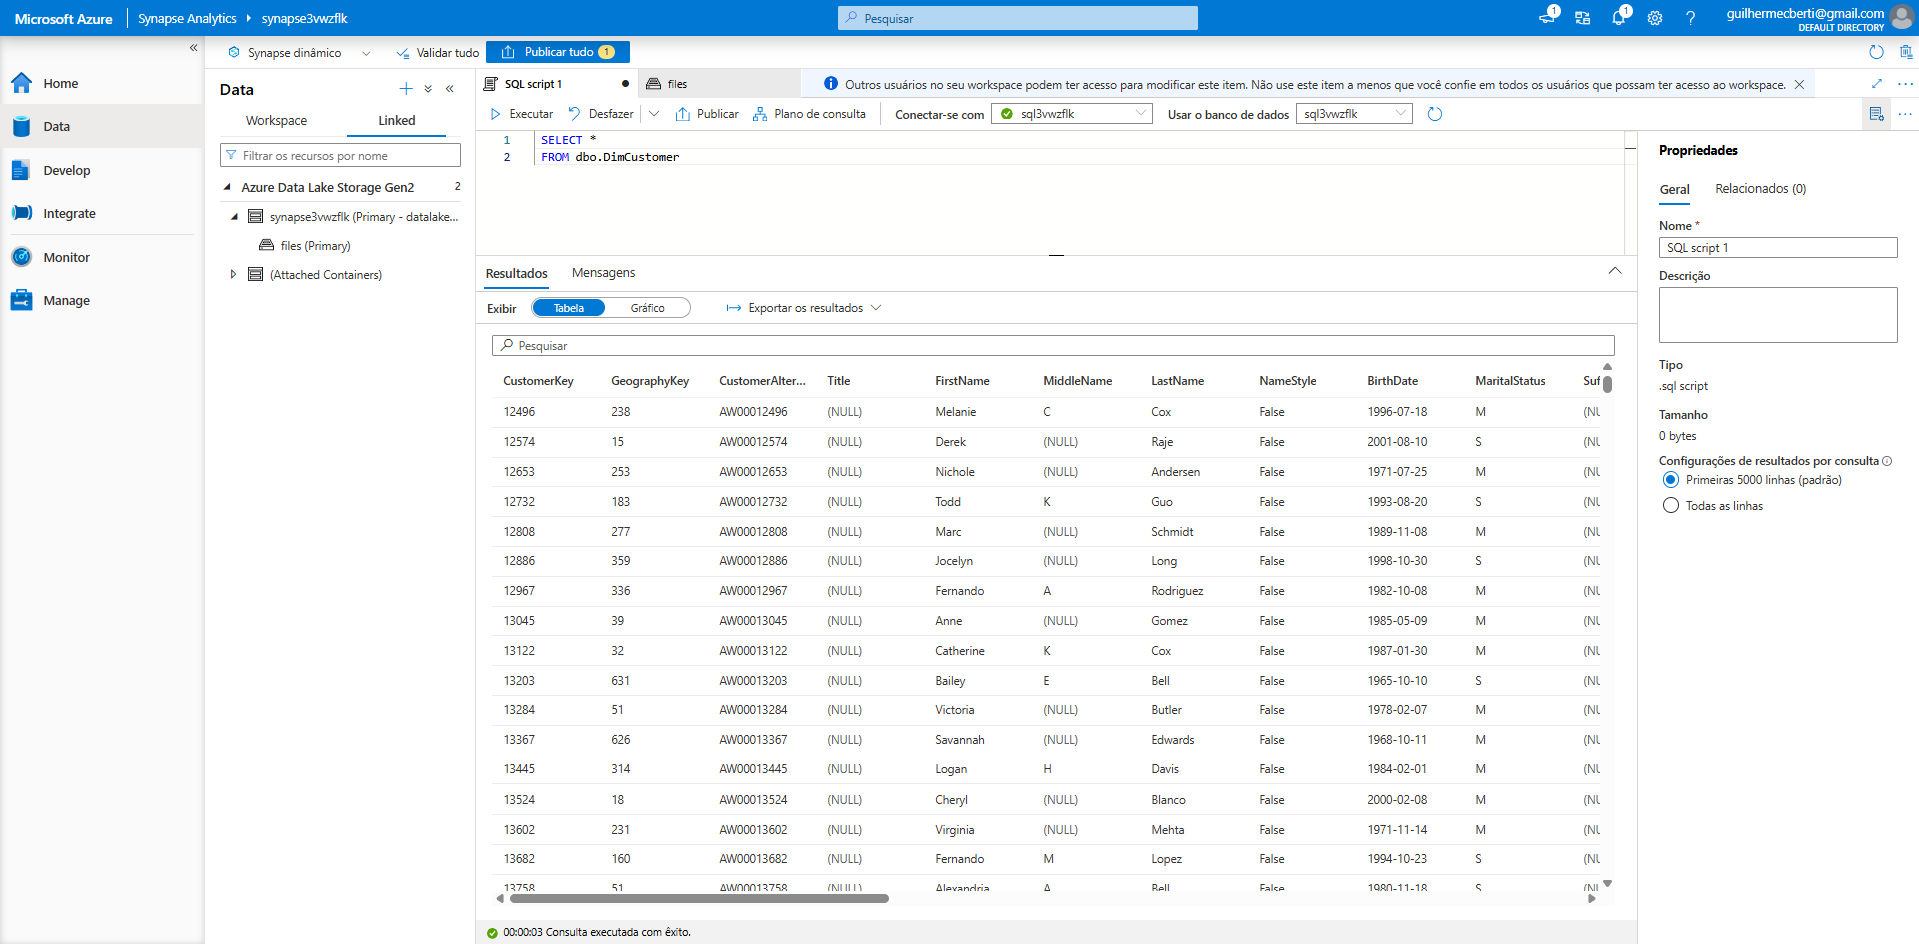

## Executar otimização pós-carregamento

Execute o script para reconstruir os índices na tabela DimProduct.

In [ ]:
 ALTER INDEX ALL ON dbo.DimProduct REBUILD;

Execute o script para criar ou atualizar estatísticas na coluna GeographyKey da tabela DimCustomer.

In [ ]:
 CREATE STATISTICS customergeo_stats
 ON dbo.DimCustomer (GeographyKey);